
找到至少 1 个能够提升模型效果的衍生变量（以 lightgbm 为基础模型）。

附件里是作业要用到的数据集，其中 loan_status 是 y 值

第一次写比较复杂的ml程序，参考了github的l1n4n同学的程序，非常感谢。

# Import data from GoogleDrive


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/ml_data/

Description.xlsx  test_final.csv  train_final.csv


In [3]:
!pip install lightgbm==3.1 --install-option=--gpu
!pip install xgboost catboost category-encoders sklearn pandas==1.1.5

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 757kB 9.1MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
    Running setup.py install for lightgbm ... done
     |████████████████████████████████| 65.7MB 80kB/s 
     |████████████████████████████████| 81kB 10.7MB/s 


In [4]:
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
from hyperopt import space_eval
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import torch
import copy
import seaborn as sns

In [5]:
train = pd.read_csv('drive/MyDrive/ml_data/train_final.csv', engine='python')
test = pd.read_csv('drive/MyDrive/ml_data/test_final.csv', engine='python')

# Pre-processing

In [6]:
kfold = KFold(n_splits=5, shuffle=True)
SEED = 31415
np.random.seed(SEED)
cpu_count = 4
use_gpu = True

## A Wrapper

In [7]:
@dataclass
class LGBOpt:
    '''
    Some params are changed, due to don't have much time left for assignment.
    '''
    num_threads: any = hp.choice('num_threads', [cpu_count])
    # num_leaves: any = hp.choice('num_leaves', [30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 60, 70]) 
    # smaller leaves to speedup.
    num_leaves: any = hp.choice('num_leaves', [30])
    metric: any = hp.choice('metric', ['binary_error'])
    # num_round: any = hp.choice('num_rounds', [2000]) # This seems enough
    # smaller rounds to speedup
    num_round: any = hp.choice('num_rounds', [100]) # might not enough
    objective: any = hp.choice('objective', ['binary'])
    # learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    # make learning_rate bigger to speedup
    learning_rate: any = hp.uniform('learning_rate', 0.09, 0.1)
    # learning_rate: any = hp.uniform('learning_rate', 0.18, 0.2)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
    boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [8]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return 1 - roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")


In [9]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

## Pipeline

In [10]:
def pipeline(new_train:pd.DataFrame, new_test:pd.DataFrame, new_feature:str, seed:int, kfold):    
    print('\nBegin experiment with {}...'.format(new_feature))
    fitter = LGBFitter(label='loan_status')

    ret = fitter.search_k_fold(kfold, new_train)
    best_p = space_eval(asdict(fitter.opt), fitter.opt_params)
    print(best_p)

    fitter = LGBFitter(label='loan_status')
    # train_data, dev_data = train_test_split(new_train, test_size=0.2, random_state=seed, stratify=train['loan_status'])

    output = fitter.train_k_fold(kfold, new_train, new_test, params=best_p, use_best_eval=True)
    
    # yhat = fitter.clf.predict(new_test.drop(columns='loan_status'), num_iteration=fitter.best_round)
    test_acc = accuracy_score(new_test['loan_status'], output[1].round())
    print('Test Acc {}'.format(test_acc))
    print()
    
    return output, {new_feature: test_acc}
    

In [11]:
def eval(best_p, train, test, kfold):
    fitter = LGBFitter(label='loan_status')

    output = fitter.train_k_fold(kfold, train, test, params=best_p, use_best_eval=True)
    test_acc = accuracy_score(test['loan_status'], output[1].round())
    print(test_acc[5])

In [12]:
train.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_purpose_11_one_hot,discrete_purpose_12_one_hot,discrete_pymnt_plan_1_one_hot,discrete_sub_grade_1_one_hot,discrete_sub_grade_2_one_hot,discrete_sub_grade_3_one_hot,discrete_sub_grade_4_one_hot,discrete_sub_grade_5_one_hot,discrete_sub_grade_6_one_hot,discrete_sub_grade_7_one_hot,discrete_sub_grade_8_one_hot,discrete_sub_grade_9_one_hot,discrete_sub_grade_10_one_hot,discrete_sub_grade_11_one_hot,discrete_sub_grade_12_one_hot,discrete_sub_grade_13_one_hot,discrete_sub_grade_14_one_hot,discrete_sub_grade_15_one_hot,discrete_sub_grade_16_one_hot,discrete_sub_grade_17_one_hot,discrete_sub_grade_18_one_hot,discrete_sub_grade_19_one_hot,discrete_sub_grade_20_one_hot,discrete_sub_grade_21_one_hot,discrete_sub_grade_22_one_hot,discrete_sub_grade_23_one_hot,discrete_sub_grade_24_one_hot,discrete_sub_grade_25_one_hot,discrete_sub_grade_26_one_hot,discrete_sub_grade_27_one_hot,discrete_sub_grade_28_one_hot,discrete_sub_grade_29_one_hot,discrete_sub_grade_30_one_hot,discrete_sub_grade_31_one_hot,discrete_sub_grade_32_one_hot,discrete_sub_grade_33_one_hot,discrete_sub_grade_34_one_hot,discrete_sub_grade_35_one_hot,discrete_term_1_one_hot,discrete_term_2_one_hot
0,55000.0,NaN,0,5.91,NaN,679,675,3600,3600,1,123.03,13.99,564,560,3600,1,30.0,30.0,NaN,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,65000.0,NaN,1,16.06,NaN,719,715,24700,24700,4,820.28,11.99,699,695,24700,1,6.0,NaN,NaN,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,63000.0,71000.0,0,10.78,13.85,699,695,20000,20000,0,432.66,10.78,704,700,20000,1,NaN,NaN,NaN,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,104433.0,NaN,1,25.37,NaN,699,695,10400,10400,3,289.91,22.45,704,700,10400,1,12.0,NaN,NaN,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,34000.0,NaN,0,10.20,NaN,694,690,11950,11950,0,405.18,13.44,759,755,11950,1,NaN,NaN,NaN,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Find best parameters => ori ACC 0.91804

In [13]:
pipeline(train, test, 'original', SEED, kfold)


Begin experiment with original...
The minimum is attained in round 87
The minimum is attained in round 95
The minimum is attained in round 84
The minimum is attained in round 101
The minimum is attained in round 50
The minimum is attained in round 31
The minimum is attained in round 30
The minimum is attained in round 39
The minimum is attained in round 17
The minimum is attained in round 37
The minimum is attained in round 71
The minimum is attained in round 97
The minimum is attained in round 65
The minimum is attained in round 45
The minimum is attained in round 59
The minimum is attained in round 21
The minimum is attained in round 25
The minimum is attained in round 33
The minimum is attained in round 83
The minimum is attained in round 51
The minimum is attained in round 96
The minimum is attained in round 82
The minimum is attained in round 86
The minimum is attained in round 85
The minimum is attained in round 72
The minimum is attained in round 82
The minimum is attained in r

((array([0.61455229, 0.9893299 , 0.98566286, ..., 0.98291528, 0.99487603,
         0.99732681]),
  array([0.93106894, 0.99688008, 0.97347494, ..., 0.96642322, 0.99443271,
         0.99393864]),
  [0.07989999999999997,
   0.08340000000000003,
   0.07689999999999997,
   0.08020000000000005,
   0.07779999999999998],
   <lightgbm.basic.Booster at 0x7f16e466ee50>]),
 {'original': 0.91804})

## Correlation

In [14]:
corr = train.corr()['loan_status'].sort_values()
pd.set_option('display.max_rows', corr.shape[0]+1)
print(corr)

continuous_int_rate                      -0.309801
discrete_term_2_one_hot                  -0.236594
discrete_grade_5_one_hot                 -0.155089
discrete_grade_6_one_hot                 -0.140186
discrete_grade_3_one_hot                 -0.111315
continuous_dti                           -0.106753
continuous_inq_last_6mths                -0.098023
continuous_annual_inc_joint              -0.078364
discrete_sub_grade_11_one_hot            -0.077402
continuous_loan_amnt                     -0.075830
continuous_funded_amnt                   -0.075830
continuous_funded_amnt_inv               -0.075583
discrete_sub_grade_16_one_hot            -0.070298
discrete_sub_grade_26_one_hot            -0.069236
discrete_sub_grade_24_one_hot            -0.065462
discrete_sub_grade_28_one_hot            -0.064147
discrete_home_ownership_2_one_hot        -0.063856
discrete_sub_grade_25_one_hot            -0.063503
discrete_sub_grade_20_one_hot            -0.062807
discrete_sub_grade_13_one_hot  

## EDA

In [15]:
train.continuous_int_rate.describe()

count    50000.000000
mean        11.986125
std          4.182402
min          5.320000
25%          9.170000
50%         11.490000
75%         14.330000
max         28.990000
Name: continuous_int_rate, dtype: float64

# Derived variable check1
1.   int_rate: 贷款利率
2.   term: 还款次数
3.   grade: 贷款等级

## Binning rate

In [16]:
# binning int_rate
train['int_rate_bin'] = pd.cut(train['continuous_int_rate'], 
                                [0,5,10,15,20,25,30], 
                                labels=[0,1,2,3,4,5])
train['int_rate_bin'].value_counts()

2    20474
1    18817
3     9086
4     1279
5      344
0        0
Name: int_rate_bin, dtype: int64

In [17]:
test['int_rate_bin'] = pd.cut(test['continuous_int_rate'], 
                                [0,5,10,15,20,25,30], 
                                labels=[0,1,2,3,4,5])

## term * grade

In [18]:
new = train.filter(like='discrete_grade') * train.filter(like='term_1').values
new = new.add_suffix('_x_term1')
new2 = train.filter(like='discrete_grade') * train.filter(like='term_2').values
new2 = new2.add_suffix('_x_term2')

In [19]:
train = pd.concat([train, new, new2], axis=1)

In [20]:
new = test.filter(like='discrete_grade') * test.filter(like='term_1').values
new = new.add_suffix('_x_term1')
new2 = test.filter(like='discrete_grade') * test.filter(like='term_2').values
new2 = new2.add_suffix('_x_term2')
test = pd.concat([test, new, new2], axis=1)

## RUN pipeline => ACC 0.9177

In [21]:
res = pipeline(train, test, 'termXgrade', SEED, kfold)


Begin experiment with termXgrade...
The minimum is attained in round 67
The minimum is attained in round 77
The minimum is attained in round 97
The minimum is attained in round 96
The minimum is attained in round 77
The minimum is attained in round 55
The minimum is attained in round 98
The minimum is attained in round 64
The minimum is attained in round 39
The minimum is attained in round 97
The minimum is attained in round 67
The minimum is attained in round 57
The minimum is attained in round 62
The minimum is attained in round 86
The minimum is attained in round 51
The minimum is attained in round 35
The minimum is attained in round 99
The minimum is attained in round 89
The minimum is attained in round 50
The minimum is attained in round 80
The minimum is attained in round 101
The minimum is attained in round 32
The minimum is attained in round 76
The minimum is attained in round 78
The minimum is attained in round 62
The minimum is attained in round 99
The minimum is attained in

# Derived variable check2
1.   loan_amnt: 贷款清单金额
2.   annual_inc: 年收入
3.   dti: 用借方每月偿还的债务总额与债务总额（不包括抵押和要求的信用证贷款）的比率除以借方自我报告的每月收入。

## Binning loan_amnt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


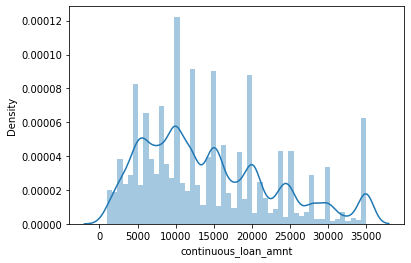

In [22]:
sns.distplot(train.continuous_loan_amnt, kde=True, bins=50)

In [23]:
# binning loan_amnt
def loan_amnt(amt):
    if amt <= 5000:
        return 0
    elif amt > 5000 and amt <=10000:
        return 1
    elif amt > 10000 and amt <=15000:
        return 2
    elif amt > 15000 and amt <= 20000:
        return 3
    else:
        return 4

train['loan_amnt_bin'] = train['continuous_loan_amnt'].apply(lambda x: loan_amnt(x))
train['loan_amnt_bin'].value_counts()

1    13557
4    10871
2    10494
3     7909
0     7169
Name: loan_amnt_bin, dtype: int64

In [24]:
test['loan_amnt_bin'] = test['continuous_loan_amnt'].apply(lambda x: loan_amnt(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


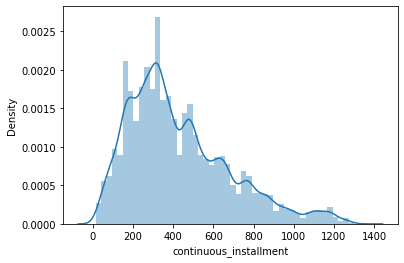

In [25]:
sns.distplot(train.continuous_installment, kde=True, bins=50)

In [26]:
# installment
def installment(n):
    if n <= 200:
        return 0
    elif n > 200 and n <=400:
        return 1
    elif n > 400 and n <=600:
        return 2
    else:
        return 3
    
train['installment_bin'] = train['continuous_installment'].apply(lambda x: installment(x))
train['installment_bin'].value_counts()

1    18243
3    11565
2    10790
0     9402
Name: installment_bin, dtype: int64

In [27]:
test['installment_bin'] = test['continuous_installment'].apply(lambda x: installment(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


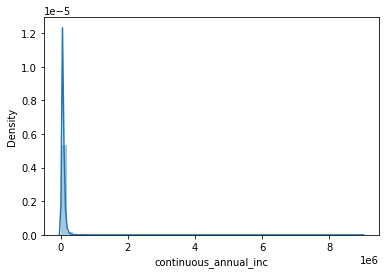

In [28]:
sns.distplot(train.continuous_annual_inc, kde=True, bins=50)

In [29]:
train.continuous_annual_inc.describe()

count    5.000000e+04
mean     7.835886e+04
std      9.783053e+04
min      0.000000e+00
25%      4.700000e+04
50%      6.500000e+04
75%      9.400000e+04
max      9.000000e+06
Name: continuous_annual_inc, dtype: float64

In [30]:
Q1 = train["continuous_annual_inc"].quantile(0.25)
Q3 = train["continuous_annual_inc"].quantile(0.75)
q95th = train["continuous_annual_inc"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR
print(Q1, Q3, q95th, IQR, UW)

47000.0 94000.0 158000.0 47000.0 164500.0


## Binning annual income

In [31]:
def annual_inc(inc):
    if inc <= 47000:
        return 1
    elif inc > 47000 and inc <= 94000:
        return 2
    elif inc > 94000 and inc <= 158000:
        return 3
    else:
        return 4

train['annual_inc_bin'] = train['continuous_annual_inc'].apply(lambda x: annual_inc(x))
train['annual_inc_bin'].value_counts()

2    24937
1    12641
3     9924
4     2498
Name: annual_inc_bin, dtype: int64

In [32]:
test['annual_inc_bin'] = test['continuous_annual_inc'].apply(lambda x: annual_inc(x))

## Binning dti

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


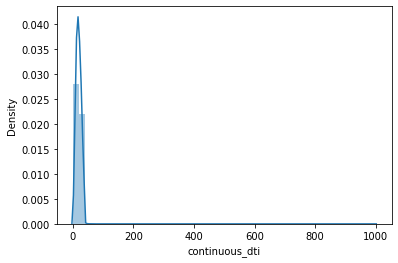

In [33]:
sns.distplot(train.continuous_dti, kde=True, bins=50)

In [34]:
train.continuous_dti.describe()

count    49999.000000
mean        19.080239
std          9.802002
min          0.000000
25%         12.410000
50%         18.520000
75%         25.320000
max        999.000000
Name: continuous_dti, dtype: float64

In [35]:
Q1 = train["continuous_dti"].quantile(0.25)
Q3 = train["continuous_dti"].quantile(0.75)
q95th = train["continuous_dti"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR
print(Q1, Q3, q95th, IQR, UW)

12.41 25.32 34.26 12.91 44.685


In [36]:
train['dti_bin'] = pd.cut(train['continuous_dti'], 
                                [0,5,10,15,20,25,30, 40], 
                                labels=[0, 1, 2, 3, 4, 5,6])
test['dti_bin'] = pd.cut(test['continuous_dti'], 
                                [0,5,10,15,20,25,30, 40], 
                                labels=[0,1,2,3,4,5,6])

## RUN pipeline => ACC 0.91774

In [37]:
res = pipeline(train, test, 'bins', SEED, kfold)


Begin experiment with bins...
The minimum is attained in round 60
The minimum is attained in round 62
The minimum is attained in round 31
The minimum is attained in round 64
The minimum is attained in round 46
The minimum is attained in round 53
The minimum is attained in round 25
The minimum is attained in round 26
The minimum is attained in round 34
The minimum is attained in round 22
The minimum is attained in round 99
The minimum is attained in round 29
The minimum is attained in round 71
The minimum is attained in round 86
The minimum is attained in round 68
The minimum is attained in round 76
The minimum is attained in round 98
The minimum is attained in round 44
The minimum is attained in round 34
The minimum is attained in round 94
The minimum is attained in round 86
The minimum is attained in round 62
The minimum is attained in round 86
The minimum is attained in round 66
The minimum is attained in round 70
The minimum is attained in round 28
The minimum is attained in round 

In [38]:
clf = res[0][-1][0]

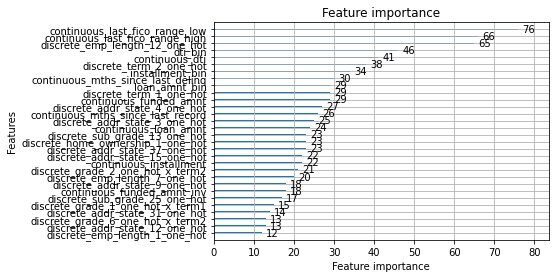

In [39]:
lgb.plot_importance(clf, max_num_features=30)

## DROP BINS

In [40]:
train.drop(columns=['loan_amnt_bin', 'installment_bin', 'annual_inc_bin', 'dti_bin'], inplace=True)
test.drop(columns=['loan_amnt_bin', 'installment_bin', 'annual_inc_bin', 'dti_bin'], inplace=True)

## Get Train

In [41]:
new = train.filter(like='discrete_sub_grade') * train.filter(like='term_1').values
new = new.add_suffix('_x_term1')
new2 = train.filter(like='discrete_sub_grade') * train.filter(like='term_2').values
new2 = new2.add_suffix('_x_term2')
train = pd.concat([train, new, new2], axis=1)
train.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_sub_grade_31_one_hot_x_term1,discrete_sub_grade_32_one_hot_x_term1,discrete_sub_grade_33_one_hot_x_term1,discrete_sub_grade_34_one_hot_x_term1,discrete_sub_grade_35_one_hot_x_term1,discrete_sub_grade_1_one_hot_x_term2,discrete_sub_grade_2_one_hot_x_term2,discrete_sub_grade_3_one_hot_x_term2,discrete_sub_grade_4_one_hot_x_term2,discrete_sub_grade_5_one_hot_x_term2,discrete_sub_grade_6_one_hot_x_term2,discrete_sub_grade_7_one_hot_x_term2,discrete_sub_grade_8_one_hot_x_term2,discrete_sub_grade_9_one_hot_x_term2,discrete_sub_grade_10_one_hot_x_term2,discrete_sub_grade_11_one_hot_x_term2,discrete_sub_grade_12_one_hot_x_term2,discrete_sub_grade_13_one_hot_x_term2,discrete_sub_grade_14_one_hot_x_term2,discrete_sub_grade_15_one_hot_x_term2,discrete_sub_grade_16_one_hot_x_term2,discrete_sub_grade_17_one_hot_x_term2,discrete_sub_grade_18_one_hot_x_term2,discrete_sub_grade_19_one_hot_x_term2,discrete_sub_grade_20_one_hot_x_term2,discrete_sub_grade_21_one_hot_x_term2,discrete_sub_grade_22_one_hot_x_term2,discrete_sub_grade_23_one_hot_x_term2,discrete_sub_grade_24_one_hot_x_term2,discrete_sub_grade_25_one_hot_x_term2,discrete_sub_grade_26_one_hot_x_term2,discrete_sub_grade_27_one_hot_x_term2,discrete_sub_grade_28_one_hot_x_term2,discrete_sub_grade_29_one_hot_x_term2,discrete_sub_grade_30_one_hot_x_term2,discrete_sub_grade_31_one_hot_x_term2,discrete_sub_grade_32_one_hot_x_term2,discrete_sub_grade_33_one_hot_x_term2,discrete_sub_grade_34_one_hot_x_term2,discrete_sub_grade_35_one_hot_x_term2
0,55000.0,NaN,0,5.91,NaN,679,675,3600,3600,1,123.03,13.99,564,560,3600,1,30.0,30.0,NaN,7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,65000.0,NaN,1,16.06,NaN,719,715,24700,24700,4,820.28,11.99,699,695,24700,1,6.0,NaN,NaN,22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,63000.0,71000.0,0,10.78,13.85,699,695,20000,20000,0,432.66,10.78,704,700,20000,1,NaN,NaN,NaN,6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,104433.0,NaN,1,25.37,NaN,699,695,10400,10400,3,289.91,22.45,704,700,10400,1,12.0,NaN,NaN,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,34000.0,NaN,0,10.20,NaN,694,690,11950,11950,0,405.18,13.44,759,755,11950,1,NaN,NaN,NaN,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Get Test

In [42]:
new = test.filter(like='discrete_sub_grade') * test.filter(like='term_1').values
new = new.add_suffix('_x_term1')
new2 = test.filter(like='discrete_sub_grade') * test.filter(like='term_2').values
new2 = new2.add_suffix('_x_term2')
test = pd.concat([test, new, new2], axis=1)
test.head()

,continuous_annual_inc,continuous_annual_inc_joint,continuous_delinq_2yrs,continuous_dti,continuous_dti_joint,continuous_fico_range_high,continuous_fico_range_low,continuous_funded_amnt,continuous_funded_amnt_inv,continuous_inq_last_6mths,continuous_installment,continuous_int_rate,continuous_last_fico_range_high,continuous_last_fico_range_low,continuous_loan_amnt,loan_status,continuous_mths_since_last_delinq,continuous_mths_since_last_major_derog,continuous_mths_since_last_record,continuous_open_acc,continuous_pub_rec,discrete_addr_state_1_one_hot,discrete_addr_state_2_one_hot,discrete_addr_state_3_one_hot,discrete_addr_state_4_one_hot,discrete_addr_state_5_one_hot,discrete_addr_state_6_one_hot,discrete_addr_state_7_one_hot,discrete_addr_state_8_one_hot,discrete_addr_state_9_one_hot,discrete_addr_state_10_one_hot,discrete_addr_state_11_one_hot,discrete_addr_state_12_one_hot,discrete_addr_state_13_one_hot,discrete_addr_state_14_one_hot,discrete_addr_state_15_one_hot,discrete_addr_state_16_one_hot,discrete_addr_state_17_one_hot,discrete_addr_state_18_one_hot,discrete_addr_state_19_one_hot,...,discrete_sub_grade_31_one_hot_x_term1,discrete_sub_grade_32_one_hot_x_term1,discrete_sub_grade_33_one_hot_x_term1,discrete_sub_grade_34_one_hot_x_term1,discrete_sub_grade_35_one_hot_x_term1,discrete_sub_grade_1_one_hot_x_term2,discrete_sub_grade_2_one_hot_x_term2,discrete_sub_grade_3_one_hot_x_term2,discrete_sub_grade_4_one_hot_x_term2,discrete_sub_grade_5_one_hot_x_term2,discrete_sub_grade_6_one_hot_x_term2,discrete_sub_grade_7_one_hot_x_term2,discrete_sub_grade_8_one_hot_x_term2,discrete_sub_grade_9_one_hot_x_term2,discrete_sub_grade_10_one_hot_x_term2,discrete_sub_grade_11_one_hot_x_term2,discrete_sub_grade_12_one_hot_x_term2,discrete_sub_grade_13_one_hot_x_term2,discrete_sub_grade_14_one_hot_x_term2,discrete_sub_grade_15_one_hot_x_term2,discrete_sub_grade_16_one_hot_x_term2,discrete_sub_grade_17_one_hot_x_term2,discrete_sub_grade_18_one_hot_x_term2,discrete_sub_grade_19_one_hot_x_term2,discrete_sub_grade_20_one_hot_x_term2,discrete_sub_grade_21_one_hot_x_term2,discrete_sub_grade_22_one_hot_x_term2,discrete_sub_grade_23_one_hot_x_term2,discrete_sub_grade_24_one_hot_x_term2,discrete_sub_grade_25_one_hot_x_term2,discrete_sub_grade_26_one_hot_x_term2,discrete_sub_grade_27_one_hot_x_term2,discrete_sub_grade_28_one_hot_x_term2,discrete_sub_grade_29_one_hot_x_term2,discrete_sub_grade_30_one_hot_x_term2,discrete_sub_grade_31_one_hot_x_term2,discrete_sub_grade_32_one_hot_x_term2,discrete_sub_grade_33_one_hot_x_term2,discrete_sub_grade_34_one_hot_x_term2,discrete_sub_grade_35_one_hot_x_term2
0,35000.0,NaN,1,25.65,NaN,664,660,13000,13000.0,1,428.63,11.49,659,655,13000,1,3.0,3.0,NaN,12,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50000.0,NaN,0,22.01,NaN,729,725,11000,11000.0,0,339.10,6.89,769,765,11000,1,NaN,NaN,NaN,25,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100000.0,NaN,0,26.39,NaN,764,760,10000,10000.0,1,301.15,5.32,684,680,10000,1,NaN,NaN,NaN,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,55000.0,NaN,0,12.26,NaN,664,660,13800,13800.0,0,318.75,13.67,724,720,13800,1,55.0,55.0,NaN,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50000.0,NaN,0,17.55,NaN,674,670,13550,13550.0,3,491.23,18.20,574,570,13550,1,29.0,82.0,NaN,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
